In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import IPython
import IPython.display

import tensorflow as tf
from keras.layers import Dense, LSTM


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# sklearn config
from sklearn import set_config
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# SƠ LƯỢC DỮ LIỆU

In [2]:
local_path = "data\MWG-20230414-1418.csv"
foreign_path = "data\MWG-20230414ndtnn.csv"

In [3]:
header_local = ['date', 'KLGD', 'GTGD', 'capital', 'close_price', 'daily_return','daily_return_pct', 'KL', 'GT']
column_range = list(range(9))
df_local = pd.read_csv(local_path, skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for local invest
df_local.columns = header_local
print(f"Dữ liệu bao gồm {df_local.shape[0]} dòng và {df_local.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_local.head()

Dữ liệu bao gồm 252 dòng và 9 cột:
Mẫu bảng dữ liệu :



,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,14/04/2023,"1,710,500","69,878","59,633","40,750",-300,-0.73,"1,710,500","69,878"
1,13/04/2023,"3,716,000","153,698","60,072","41,050",300,0.74,"3,135,000","128,411"
2,12/04/2023,"5,666,500","236,849","59,633","40,750",50,0.12,"3,970,800","163,086"
3,11/04/2023,"5,749,500","242,682","59,559","40,700",-300,-0.73,"2,852,300","115,640"
4,10/04/2023,"10,616,296","436,606","59,998","41,000","2,000",5.13,"5,829,400","236,992"


In [4]:
header_foreign = ['date', 'room', 'remain_room_stk','remain_room_pct','kl_buy','kl_buy_pct', 'gt_buy','gt_buy_pct','kl_sell','kl_sell_pct', 'gt_sell','gt_sell_pct','KL_foreign_diff','GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct']
column_range = list(range(18))
df_foreign = pd.read_csv(foreign_path, skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for foreign invest
df_foreign.columns = header_foreign
print(f"Dữ liệu bao gồm {df_foreign.shape[0]} dòng và {df_foreign.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_foreign.head()

Dữ liệu bao gồm 252 dòng và 18 cột:
Mẫu bảng dữ liệu :



,date,room,remain_room_stk,remain_room_pct,kl_buy,kl_buy_pct,gt_buy,gt_buy_pct,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,14/04/2023,"717,300,847",72,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,-,NaN,-,NaN
1,13/04/2023,"717,300,847",72,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"581,000",100,"25,286,500,000",100
2,12/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"1,695,700",100,"73,762,950,000",100
3,11/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"2,897,200",100,"127,042,220,000",100
4,10/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"5,403,900",112.89,"225,342,630,000",112.89


# PREPROCESSING

Merge 2 dataframes. We also want to remove these cols because:
* KLGD and GTGD is like KL and GT. However, the KL and GT is usually used in forcasting
* 'remain_room_stk', 'remain_room_pct' from the EDA, I dont think we need that
* For foreign data, we will remove all the room data, gt data and kl data is quite the same, so I will remove gt data 

In [5]:
df = pd.merge(df_local, df_foreign, on="date")
drop_cols = ['capital','room', 'remain_room_stk', 'remain_room_pct', 'KLGD', 'GTGD','gt_buy_pct', 'gt_sell_pct','GT_foreign_diff','AT_KL_2_pct']
df.drop(columns= drop_cols, axis=1, inplace =True) #We don't need that
df.head()

,date,close_price,daily_return,daily_return_pct,KL,GT,kl_buy,kl_buy_pct,gt_buy,kl_sell,kl_sell_pct,gt_sell,KL_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2
0,14/04/2023,"40,750",-300,-0.73,"1,710,500","69,878",-,NaN,-,-,NaN,-,-,-,NaN,-
1,13/04/2023,"41,050",300,0.74,"3,135,000","128,411",-,NaN,-,-,NaN,-,-,"581,000",100,"25,286,500,000"
2,12/04/2023,"40,750",50,0.12,"3,970,800","163,086",-,NaN,-,-,NaN,-,-,"1,695,700",100,"73,762,950,000"
3,11/04/2023,"40,700",-300,-0.73,"2,852,300","115,640",-,NaN,-,-,NaN,-,-,"2,897,200",100,"127,042,220,000"
4,10/04/2023,"41,000","2,000",5.13,"5,829,400","236,992",-,NaN,-,-,NaN,-,-,"5,403,900",112.89,"225,342,630,000"


In [6]:
df.columns

Index(['date', 'close_price', 'daily_return', 'daily_return_pct', 'KL', 'GT',
       'kl_buy', 'kl_buy_pct', 'gt_buy', 'kl_sell', 'kl_sell_pct', 'gt_sell',
       'KL_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2'],
      dtype='object')

Feature engineer with date time

In [7]:
# Convert the date column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.sort_values(by='date', ascending=True, ignore_index = True)

In [8]:
df.head()

,date,close_price,daily_return,daily_return_pct,KL,GT,kl_buy,kl_buy_pct,gt_buy,kl_sell,kl_sell_pct,gt_sell,KL_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2
0,2022-04-14,"159,500","3,300",2.11,"2,925,900","467,335",-,NaN,-,-,NaN,-,-,-,NaN,-
1,2022-04-15,"160,200",700,0.44,"2,339,800","374,329",-,NaN,-,-,NaN,-,-,"620,000",100,"105,772,000,000"
2,2022-04-18,"160,200",NaN,NaN,"2,616,900","420,385",-,NaN,-,"3,800",0.15,"612,110,000","-3,800","316,900",100,"54,316,660,000"
3,2022-04-19,"156,000","-4,200",-2.62,"3,285,000","520,237",-,NaN,-,-,NaN,-,-,"796,200",100,"136,468,680,000"
4,2022-04-20,"156,000",NaN,NaN,"1,900,700","296,421",-,NaN,-,-,NaN,-,-,"300,000",100,"50,070,000,000"


Convert data types and fill NaN

In [9]:
def convert_type(dataframe):
    dataframe = dataframe.fillna(0)
    for col in dataframe.columns:
        if col == 'date':
            continue
        else:
            dataframe[col] = dataframe[col].apply(
                lambda x: float(str(x).replace(',', '').replace('-', '0'))
                if isinstance(x, str) and x.strip() != ''
                else (np.nan if isinstance(x, str) and x.strip() == '' else x)
            )
    return dataframe
df = convert_type(df)

In [10]:
df_temp = df.copy()

* Moving average. I want to see the trend in weeks, months. The bigger picture. 
* Now I have the MA. Because after using standardize, all the data is scale, we don't know if the volumn is higher or lower compared to the MA_vol. So I make a different columns to capture that. Its like daily return column. But for the volumne

In [11]:
# The MA for close price
ma_day = [10, 20]
for ma in ma_day:
    column_name = f"MA{ma}"
    df[column_name] = df['close_price'].rolling(ma).mean()
    df[f"close_MA{ma}"] = df["close_price"] - df[column_name]

In [12]:
# The MA for volumne
ma_vol = 20
column_name = f"MA{ma_vol}_vol"
df[column_name] = df['KL'].rolling(ma_vol).mean()
df[f"close_MA{ma_vol}_vol"] = df["close_price"] - df[column_name]

The change of volume each day

In [13]:
# We'll use pct_change to find the percent change for each day
return_cols = ['KL', 'GT']
for col in return_cols:
    df[f'Daily_Return_{col}_pct'] = df[col].pct_change()

In [14]:
df = df.dropna()
df.tail(10)

,date,close_price,daily_return,daily_return_pct,KL,GT,kl_buy,kl_buy_pct,gt_buy,kl_sell,...,AT_KL_1_pct,AT_KL_2,MA10,close_MA10,MA20,close_MA20,MA20_vol,close_MA20_vol,Daily_Return_KL_pct,Daily_Return_GT_pct
242,2023-04-03,39000.0,450.0,1.17,2112100.0,82191.0,59.0,0.00,0.0,100.0,...,129.61,4.420760e+10,38425.0,575.0,38900.0,100.0,1902730.0,-1863730.0,0.163371,0.171396
243,2023-04-04,39800.0,800.0,2.05,3133300.0,124141.0,0.0,0.00,0.0,0.0,...,0.00,0.000000e+00,38555.0,1245.0,38905.0,895.0,1980110.0,-1940310.0,0.483500,0.510397
244,2023-04-05,39750.0,50.0,-0.13,1735900.0,68838.0,0.0,0.00,0.0,0.0,...,0.00,0.000000e+00,38735.0,1015.0,38922.5,827.5,1965450.0,-1925700.0,-0.445983,-0.445485
245,2023-04-06,39100.0,650.0,-1.64,1971300.0,78034.0,100.0,0.01,4000000.0,0.0,...,100.00,2.379150e+10,38865.0,235.0,38877.5,222.5,1958215.0,-1919115.0,0.135607,0.133589
246,2023-04-07,39000.0,100.0,-0.26,2032200.0,78830.0,0.0,0.00,0.0,0.0,...,100.00,2.628384e+10,38970.0,30.0,38840.0,160.0,1981175.0,-1942175.0,0.030893,0.010201
247,2023-04-10,41000.0,2000.0,5.13,5829400.0,236992.0,0.0,0.00,0.0,0.0,...,112.89,2.253426e+11,39260.0,1740.0,38920.0,2080.0,2205190.0,-2164190.0,1.868517,2.006368
248,2023-04-11,40700.0,300.0,-0.73,2852300.0,115640.0,0.0,0.00,0.0,0.0,...,100.00,1.270422e+11,39420.0,1280.0,39025.0,1675.0,2267225.0,-2226525.0,-0.510704,-0.512051
249,2023-04-12,40750.0,50.0,0.12,3970800.0,163086.0,0.0,0.00,0.0,0.0,...,100.00,7.376295e+10,39625.0,1125.0,39062.5,1687.5,2370805.0,-2330055.0,0.392140,0.410291
250,2023-04-13,41050.0,300.0,0.74,3135000.0,128411.0,0.0,0.00,0.0,0.0,...,100.00,2.528650e+10,39870.0,1180.0,39145.0,1905.0,2444305.0,-2403255.0,-0.210487,-0.212618
251,2023-04-14,40750.0,300.0,-0.73,1710500.0,69878.0,0.0,0.00,0.0,0.0,...,0.00,0.000000e+00,40090.0,660.0,39212.5,1537.5,2482140.0,-2441390.0,-0.454386,-0.455825


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 19 to 251
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 233 non-null    datetime64[ns]
 1   close_price          233 non-null    float64       
 2   daily_return         233 non-null    float64       
 3   daily_return_pct     233 non-null    float64       
 4   KL                   233 non-null    float64       
 5   GT                   233 non-null    float64       
 6   kl_buy               233 non-null    float64       
 7   kl_buy_pct           233 non-null    float64       
 8   gt_buy               233 non-null    float64       
 9   kl_sell              233 non-null    float64       
 10  kl_sell_pct          233 non-null    float64       
 11  gt_sell              233 non-null    float64       
 12  KL_foreign_diff      233 non-null    float64       
 13  AT_KL_1              233 non-null 

In [16]:
df.describe()

,close_price,daily_return,daily_return_pct,KL,GT,kl_buy,kl_buy_pct,gt_buy,kl_sell,kl_sell_pct,...,AT_KL_1_pct,AT_KL_2,MA10,close_MA10,MA20,close_MA20,MA20_vol,close_MA20_vol,Daily_Return_KL_pct,Daily_Return_GT_pct
count,233.000000,233.000000,233.000000,2.330000e+02,233.000000,2.330000e+02,233.000000,2.330000e+02,2.330000e+02,233.000000,...,233.000000,2.330000e+02,233.000000,233.000000,233.000000,233.000000,2.330000e+02,2.330000e+02,233.000000,233.000000
mean,62087.553648,1282.618026,-0.171888,2.867535e+06,171532.557940,1.412320e+05,4.094120,9.422350e+09,1.495824e+05,4.201202,...,73.333777,3.701607e+10,64034.763948,-1947.210300,66394.667382,-4307.113734,2.833471e+06,-2.771384e+06,0.140442,0.131444
std,29554.971714,1526.422602,2.840170,1.603990e+06,108815.092234,5.592819e+05,12.658487,3.190153e+10,5.679554e+05,12.642201,...,50.455682,6.000884e+10,30644.675841,8741.219803,32009.993264,12763.556897,8.834771e+05,8.924894e+05,0.645706,0.634234
min,37700.000000,0.000000,-6.990000,5.421000e+05,34268.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,38335.000000,-63730.000000,38840.000000,-62655.000000,1.313240e+06,-4.435790e+06,-0.733514,-0.733764
25%,42750.000000,300.000000,-1.520000,1.675300e+06,87019.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,43120.000000,-2610.000000,43997.500000,-5605.000000,2.013980e+06,-3.339420e+06,-0.311165,-0.303607
50%,52000.000000,800.000000,-0.110000,2.550700e+06,152161.000000,0.000000e+00,0.000000,0.000000e+00,1.800000e+01,0.000000,...,100.000000,1.365180e+10,56170.000000,-525.000000,57725.000000,-1797.500000,3.009200e+06,-2.957600e+06,-0.025259,-0.039353
75%,67100.000000,1600.000000,1.280000,3.748300e+06,235083.000000,5.000000e+03,0.200000,2.225600e+08,7.400000e+03,0.270000,...,100.000000,5.344350e+10,69070.000000,1040.000000,69710.000000,1675.000000,3.404420e+06,-1.957395e+06,0.376829,0.366352
max,154700.000000,10000.000000,6.990000,1.084750e+07,778223.000000,6.754080e+06,108.590000,3.256277e+11,6.754080e+06,108.590000,...,274.380000,4.275500e+11,150040.000000,12340.000000,148040.000000,15930.000000,4.507490e+06,-1.163240e+06,4.206330,3.866456


Some data have range so big that we have to log_transform like:
* kl_buy
* gt_buy
* kl_sell
* AT_KL_2
* AT_KL_1

In [17]:
df.drop(columns=['date'], axis=1, inplace= True)

Normalize data - Pipeline

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
df.columns

Index(['close_price', 'daily_return', 'daily_return_pct', 'KL', 'GT', 'kl_buy',
       'kl_buy_pct', 'gt_buy', 'kl_sell', 'kl_sell_pct', 'gt_sell',
       'KL_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'MA10',
       'close_MA10', 'MA20', 'close_MA20', 'MA20_vol', 'close_MA20_vol',
       'Daily_Return_KL_pct', 'Daily_Return_GT_pct'],
      dtype='object')

In [20]:
df.head()

,close_price,daily_return,daily_return_pct,KL,GT,kl_buy,kl_buy_pct,gt_buy,kl_sell,kl_sell_pct,...,AT_KL_1_pct,AT_KL_2,MA10,close_MA10,MA20,close_MA20,MA20_vol,close_MA20_vol,Daily_Return_KL_pct,Daily_Return_GT_pct
0,125100.0,9300.0,-6.92,2746800.0,359383.0,0.0,0.00,0.0,0.0,0.0,...,100.0,1.221869e+11,141670.0,-16570.0,148040.0,-22940.0,2218695.0,-2093595.0,0.610460,0.541371
1,123000.0,2100.0,-1.68,1334500.0,168692.0,1000.0,0.07,0.0,0.0,0.0,...,100.0,3.973860e+09,139470.0,-16470.0,146215.0,-23215.0,2139125.0,-2016125.0,-0.514162,-0.530607
2,131600.0,8600.0,6.99,1055800.0,134181.0,1000.0,0.09,124900000.0,0.0,0.0,...,0.0,0.000000e+00,137710.0,-6110.0,144785.0,-13185.0,2074925.0,-1943325.0,-0.208842,-0.204580
3,133500.0,1900.0,1.44,805600.0,105969.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.000000e+00,136110.0,-2610.0,143450.0,-9950.0,1984360.0,-1850860.0,-0.236977,-0.210253
4,133000.0,500.0,-0.37,839200.0,110730.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.000000e+00,134470.0,-1470.0,142300.0,-9300.0,1862070.0,-1729070.0,0.041708,0.044928


In [21]:
def divide_1000 (x):
    return x/1000
def log_transform(x): # normalize các cột có data range lớn
    return np.log(x + 1)

In [22]:
df.columns

Index(['close_price', 'daily_return', 'daily_return_pct', 'KL', 'GT', 'kl_buy',
       'kl_buy_pct', 'gt_buy', 'kl_sell', 'kl_sell_pct', 'gt_sell',
       'KL_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'MA10',
       'close_MA10', 'MA20', 'close_MA20', 'MA20_vol', 'close_MA20_vol',
       'Daily_Return_KL_pct', 'Daily_Return_GT_pct'],
      dtype='object')

In [23]:
other_cols = ['daily_return_pct', 'kl_buy_pct', 
              'AT_KL_1_pct','kl_sell_pct','Daily_Return_KL_pct', 'Daily_Return_GT_pct'] #Won't apply anything
log_cols = ['kl_buy','gt_buy','kl_sell', 'AT_KL_2','AT_KL_1']
standardize_cols = [element for element in df.columns.to_list() if (element not in other_cols) and (element not in log_cols)]

def remove_drop_columns(array, drop_cols = drop_cols): # to check if the element in array is in drop_cols
    return [item for item in array if item not in drop_cols] 

for cols in [other_cols,log_cols,standardize_cols]:
    cols = remove_drop_columns(cols)
    
print (standardize_cols)

['close_price', 'daily_return', 'KL', 'GT', 'gt_sell', 'KL_foreign_diff', 'MA10', 'close_MA10', 'MA20', 'close_MA20', 'MA20_vol', 'close_MA20_vol']


In [24]:
standardize_pipe = Pipeline(steps=[('divide_1000', FunctionTransformer(divide_1000)), ('standard scaler',StandardScaler())])
log_pipe = Pipeline(steps=[('log_transform', FunctionTransformer(log_transform)), ('standard scaler',StandardScaler())])

transformer = ColumnTransformer(transformers=[('standardize_pipe',standardize_pipe, standardize_cols), ('log_pipe',log_pipe, log_cols)])

In [25]:
df_temp = df.copy()

In [26]:
def dataframe_pipe_trans(dataframe, standardize_cols = standardize_cols, log_cols =log_cols):
    # Standardize pipe
    standardize_pipe.fit(dataframe[standardize_cols])
    standardized_df = pd.DataFrame(standardize_pipe.transform(dataframe[standardize_cols]), columns=standardize_cols)

    # Log pipe
    log_pipe.fit(dataframe[log_cols])
    log_df = pd.DataFrame(log_pipe.transform(dataframe[log_cols]), columns=log_cols)

    # Combine standardized and log transformed columns
    transformed_df = pd.concat([standardized_df, log_df], axis=1)
    transformed_df.reset_index(drop=True, inplace=True)

    return transformed_df
df_trans = dataframe_pipe_trans(df)
df_trans.head()

,close_price,daily_return,KL,GT,gt_sell,KL_foreign_diff,MA10,close_MA10,MA20,close_MA20,MA20_vol,close_MA20_vol,kl_buy,gt_buy,kl_sell,AT_KL_2,AT_KL_1
0,2.136632,5.263708,-0.075434,1.730044,-0.308467,-0.31639,2.538855,-1.676456,2.556111,-1.462993,-0.697358,0.761071,-0.836398,-0.792411,-0.911001,0.880258,0.689555
1,2.065425,0.536641,-0.957821,-0.026161,-0.308467,-0.31292,2.466909,-1.664991,2.498975,-1.484586,-0.787616,0.848060,0.538355,-0.792411,-0.911001,0.587411,0.128375
2,2.357035,4.804132,-1.131949,-0.343996,-0.308467,-0.31292,2.409353,-0.477251,2.454205,-0.697063,-0.860440,0.929805,0.538355,1.003445,-0.911001,-1.302012,-1.594959
3,2.421460,0.405334,-1.288271,-0.603820,-0.308467,-0.31639,2.357029,-0.075987,2.412410,-0.443061,-0.963171,1.033632,-0.836398,-0.792411,-0.911001,-1.302012,-1.594959
4,2.404506,-0.513818,-1.267278,-0.559972,-0.308467,-0.31639,2.303398,0.054711,2.376406,-0.392025,-1.101888,1.170387,-0.836398,-0.792411,-0.911001,-1.302012,-1.594959


In [27]:
for col in other_cols:
    df_trans[col] = df[col]

In [28]:
df_trans.head()

,close_price,daily_return,KL,GT,gt_sell,KL_foreign_diff,MA10,close_MA10,MA20,close_MA20,...,gt_buy,kl_sell,AT_KL_2,AT_KL_1,daily_return_pct,kl_buy_pct,AT_KL_1_pct,kl_sell_pct,Daily_Return_KL_pct,Daily_Return_GT_pct
0,2.136632,5.263708,-0.075434,1.730044,-0.308467,-0.31639,2.538855,-1.676456,2.556111,-1.462993,...,-0.792411,-0.911001,0.880258,0.689555,-6.92,0.00,100.0,0.0,0.610460,0.541371
1,2.065425,0.536641,-0.957821,-0.026161,-0.308467,-0.31292,2.466909,-1.664991,2.498975,-1.484586,...,-0.792411,-0.911001,0.587411,0.128375,-1.68,0.07,100.0,0.0,-0.514162,-0.530607
2,2.357035,4.804132,-1.131949,-0.343996,-0.308467,-0.31292,2.409353,-0.477251,2.454205,-0.697063,...,1.003445,-0.911001,-1.302012,-1.594959,6.99,0.09,0.0,0.0,-0.208842,-0.204580
3,2.421460,0.405334,-1.288271,-0.603820,-0.308467,-0.31639,2.357029,-0.075987,2.412410,-0.443061,...,-0.792411,-0.911001,-1.302012,-1.594959,1.44,0.00,0.0,0.0,-0.236977,-0.210253
4,2.404506,-0.513818,-1.267278,-0.559972,-0.308467,-0.31639,2.303398,0.054711,2.376406,-0.392025,...,-0.792411,-0.911001,-1.302012,-1.594959,-0.37,0.00,0.0,0.0,0.041708,0.044928


Split data

In [29]:
# Get the number of rows to train the model on
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df_trans)
train_df = df_trans[0:int(n*0.7)]
val_df = df_trans[int(n*0.7):int(n*0.9)]
test_df = df_trans[int(n*0.9):]

num_features = df_trans.shape[1]
print ('len(train_df)',len(train_df))

len(train_df) 163


# TRAINING

Make sliding window

In [30]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [31]:
OUT_STEPS = 5
input_width =15 
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns = ['close_price'])
multi_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [15 16 17 18 19]
Label column name(s): ['close_price']

Split Window

In [32]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [33]:
# Example for split window
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[50:50+multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 20, 23)
Inputs shape: (3, 15, 23)
Labels shape: (3, 5, 1)


Plot

In [34]:
def plot(self, model=None, plot_col='close_price', max_subplots=3):
    
    inputs, labels = self.split_window(example_window)
    plt.figure(figsize=(20, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [day]')

WindowGenerator.plot = plot

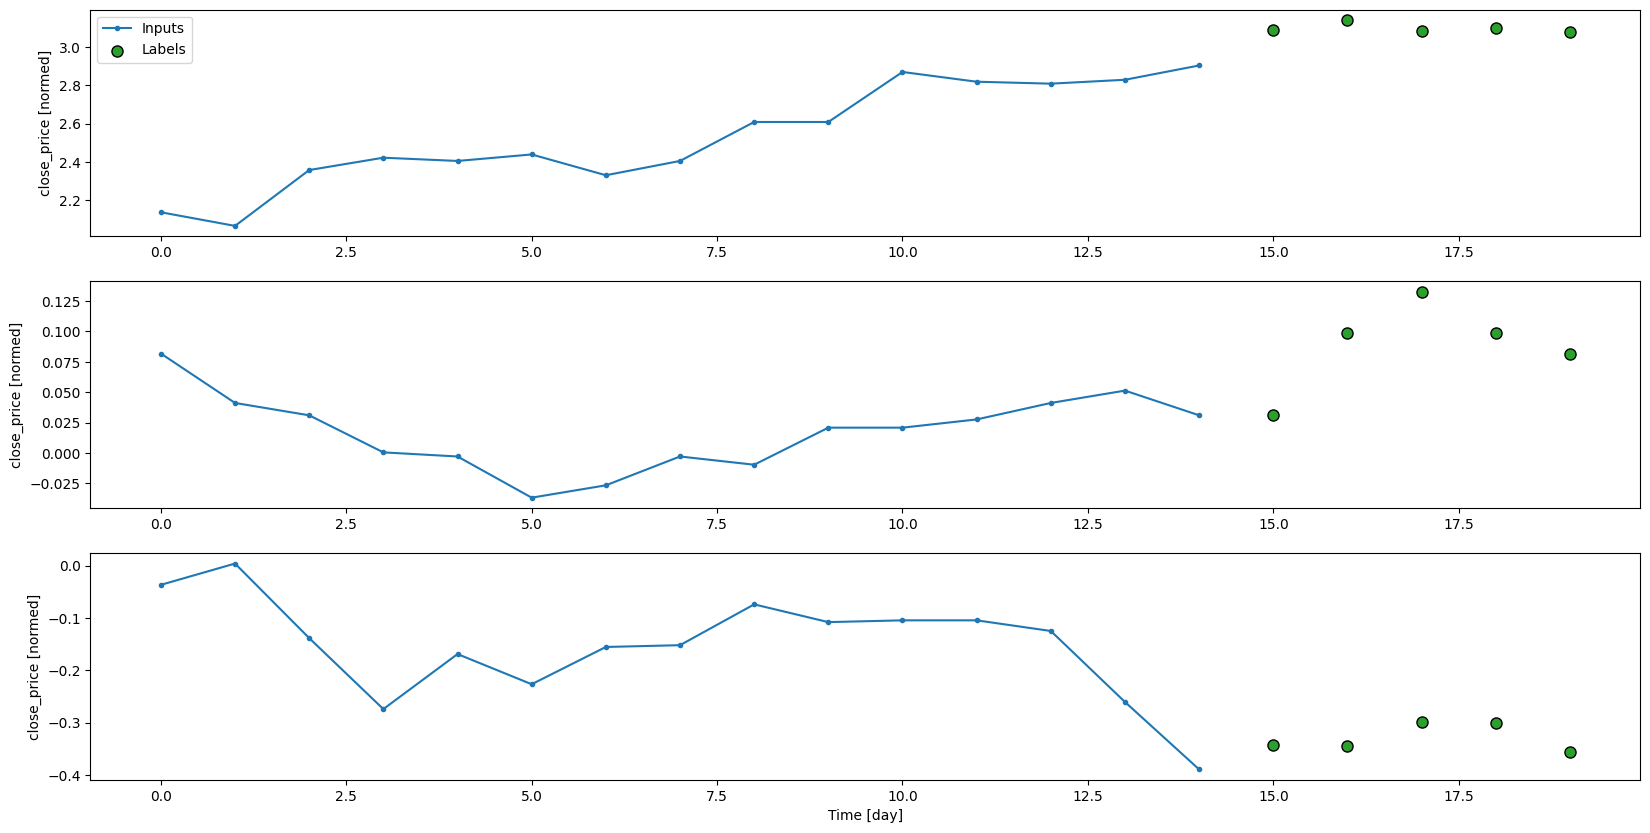

In [35]:
multi_window.plot()

Create dataset

In [36]:
def make_dataset(self, data): #data lấy liên tục 
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,#to avoid sequence bias
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [37]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [38]:
for inputs, labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 15, 23)
Labels shape (batch, time, features): (32, 5, 1)


In [39]:
multi_window.train

<_MapDataset element_spec=(TensorSpec(shape=(None, 15, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))>

Build and Train model

In [40]:
tf.keras.backend.clear_session()
MAX_EPOCHS = 100

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

        
    model.compile(#loss=tf.keras.losses.MeanSquaredError()
                  loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,lr_schedule],verbose=1)
    return history

In [41]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

Simple CNN

In [42]:
CONV_WIDTH =3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

1/1 [==============================] - 0s 30ms/step - loss: 0.1740 - mean_absolute_error: 0.5495 - root_mean_squared_error: 0.5907
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


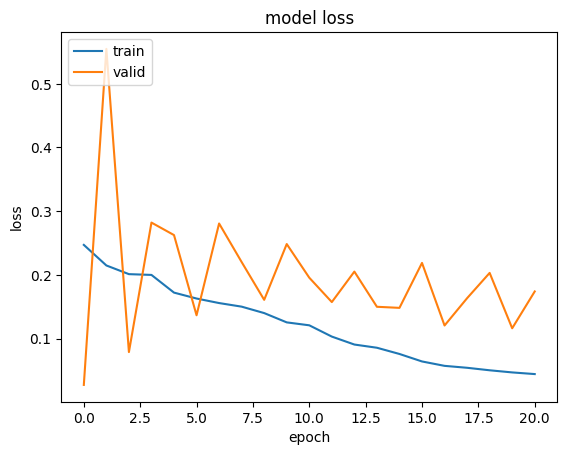

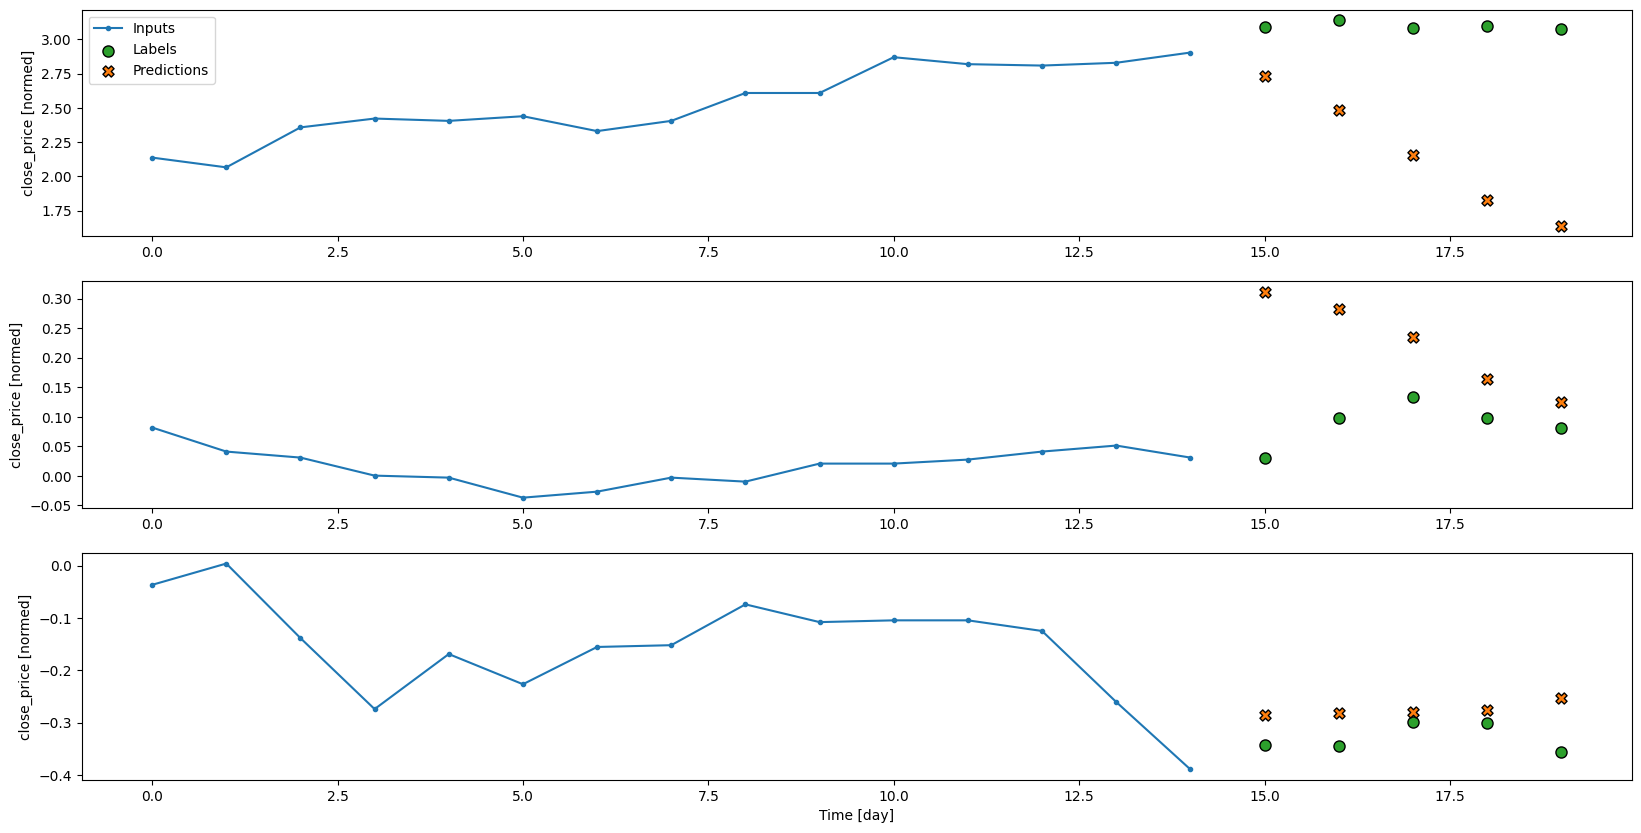

In [43]:
multi_conv_history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()

multi_val_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
plot_train(multi_conv_history)
multi_window.plot(multi_conv_model)

In [44]:
multi_conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 3, 23)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            17920     
                                                                 
 dense (Dense)               (None, 1, 115)            29555     
                                                                 
 reshape (Reshape)           (None, 5, 23)             0         
                                                                 
Total params: 47,475
Trainable params: 47,475
Non-trainable params: 0
_________________________________________________________________


Multi LSTM

1/1 [==============================] - 0s 114ms/step - loss: 0.1332 - mean_absolute_error: 0.4301 - root_mean_squared_error: 0.5169
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


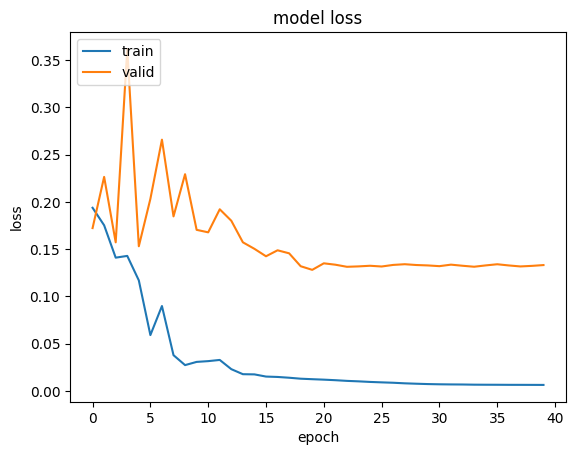

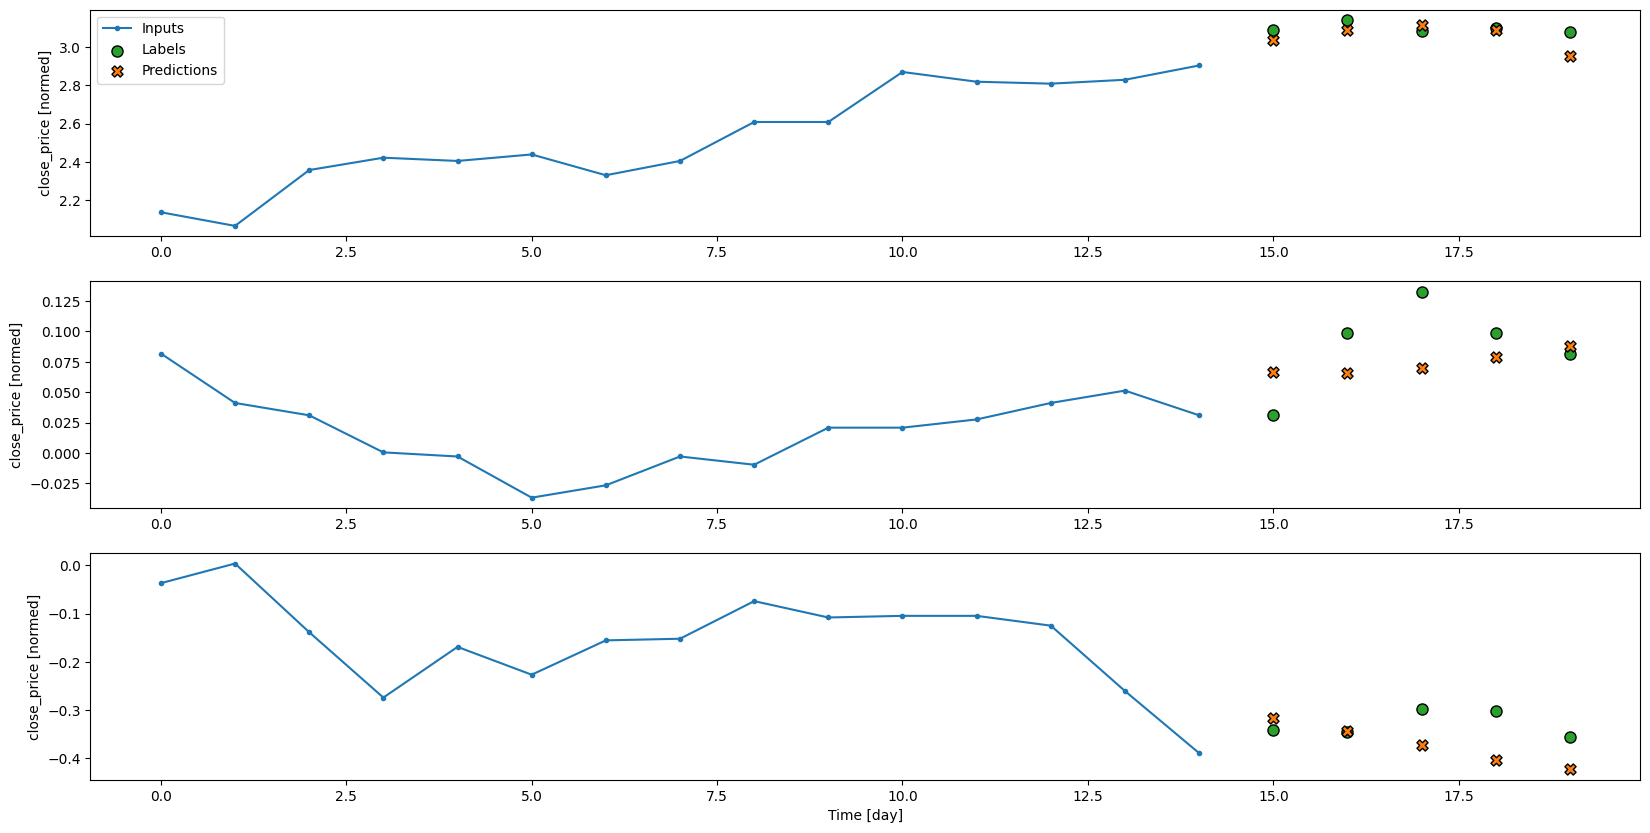

In [45]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(1024, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.LSTM(1024, return_sequences=False),
    
    tf.keras.layers.Dense(512, activation = 'relu'), 
    
    tf.keras.layers.Dense(256),
    
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_multi_lstm = compile_and_fit(multi_lstm_model, multi_window)
IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
plot_train(history_multi_lstm)
multi_window.plot(multi_lstm_model)

In [46]:
multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 1024)          4292608   
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 115)               29555     
                                                                 
 reshape_1 (Reshape)         (None, 5, 23)             0         
                                                                 
Total params: 13,370,995
Trainable params: 13,370,995


Complex CNN

In [47]:
CONV_WIDTH = 3

def build_CNN_model(input_shape = (input_width,num_features)): #input_shape (time steps,features)
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)

    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x) 
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(512)(x)
                              
    x = tf.keras.layers.Dense(OUT_STEPS*num_features) (x)
    # Shape => [batch, out_steps, features]
    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_model = build_CNN_model()
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 23, 1)]       0         
                                                                 
 time_distributed (TimeDistr  (None, 15, 21, 64)       256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 19, 128)      24704     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 17, 256)      98560     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 15, 128)      98432     
 tributed)                                                   

1/1 [==============================] - 0s 69ms/step - loss: 0.1875 - mean_absolute_error: 0.5663 - root_mean_squared_error: 0.6124
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


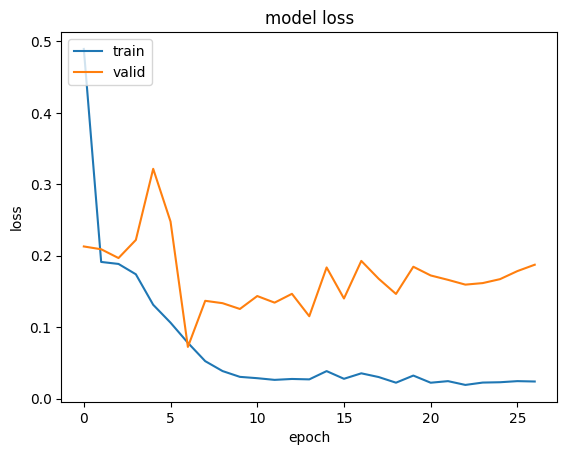

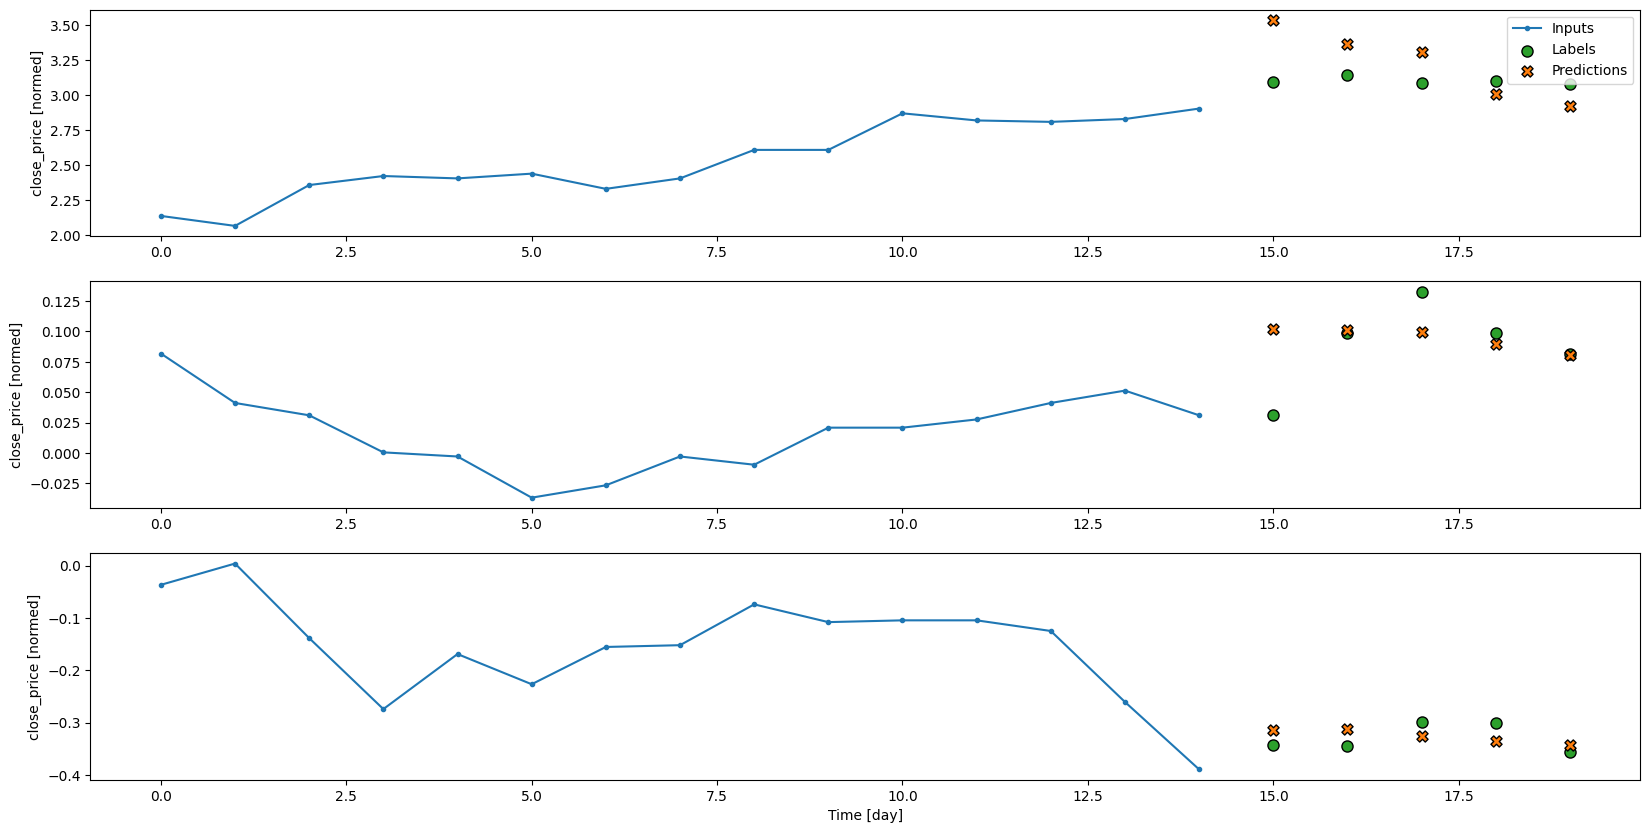

In [48]:
tf.keras.backend.clear_session()
history_CNN = compile_and_fit(CNN_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN'] = CNN_model.evaluate(multi_window.val)
multi_performance['CNN'] = CNN_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN)
multi_window.plot(CNN_model)

CNN + LSTM

In [49]:
CONV_WIDTH = 3

def build_CNN_LSTM_model(input_shape = (input_width,num_features)):
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    # x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_LSTM_model = build_CNN_LSTM_model()
CNN_LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 23, 1)]       0         
                                                                 
 time_distributed (TimeDistr  (None, 15, 21, 64)       256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 10, 64)       0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 8, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 4, 128)       0         
 tributed)                                                   

1/1 [==============================] - 0s 45ms/step - loss: 0.2042 - mean_absolute_error: 0.6173 - root_mean_squared_error: 0.6390
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


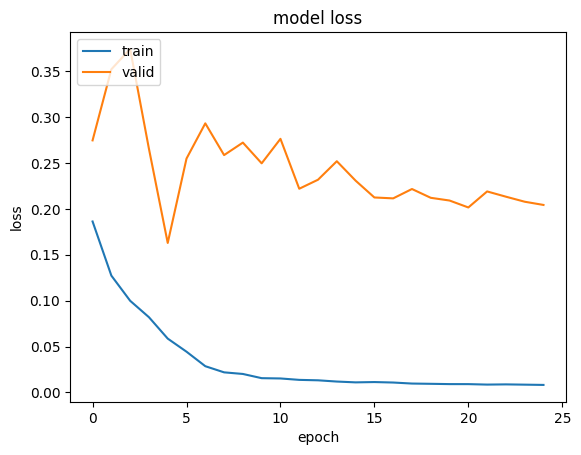

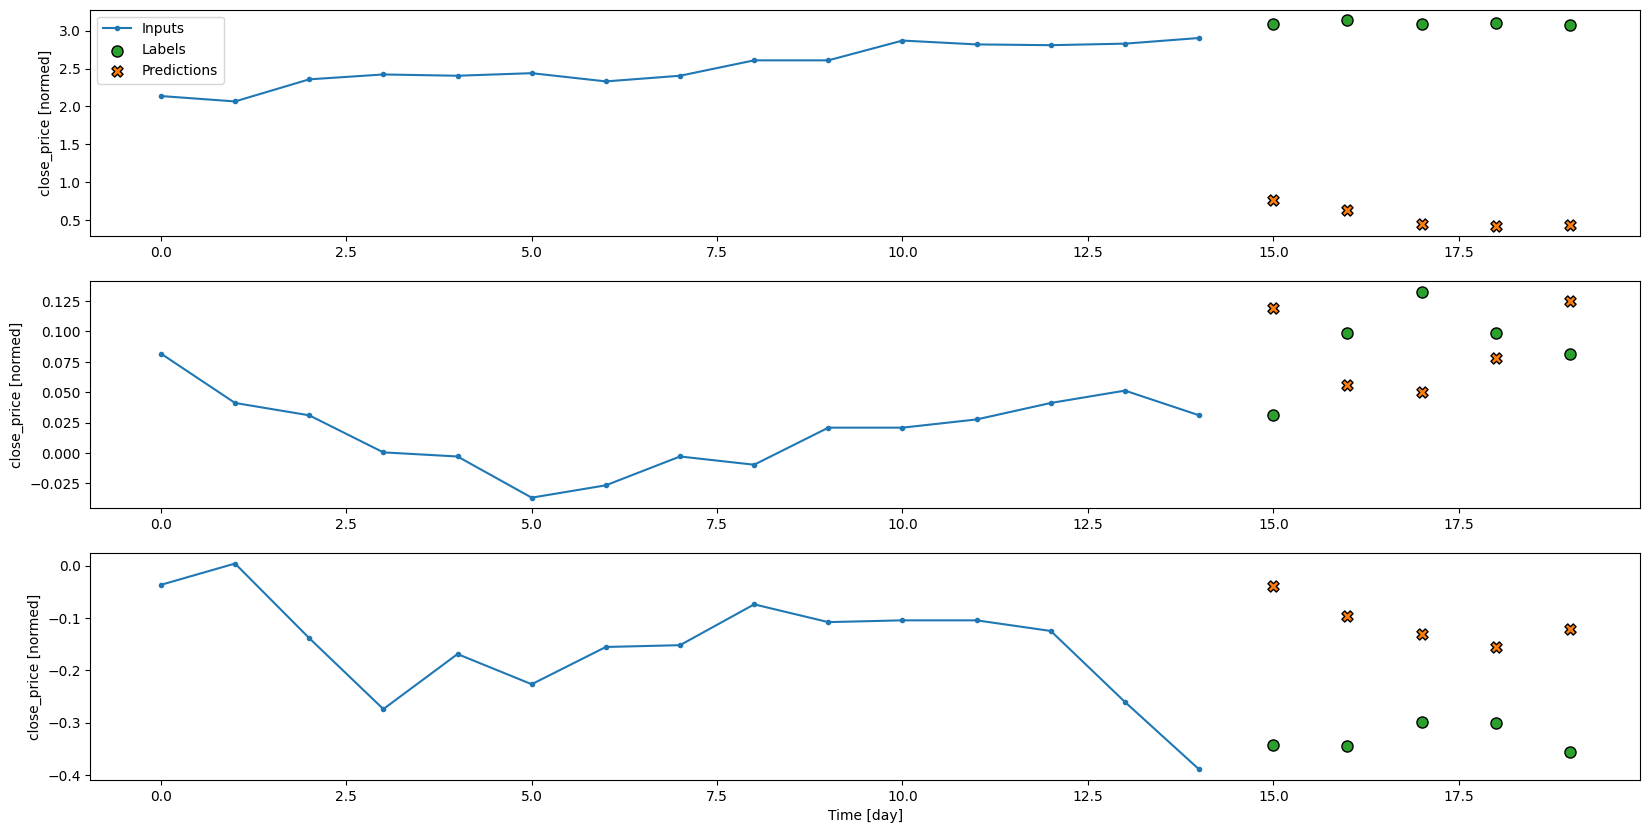

In [50]:
history_CNN_LSTM = compile_and_fit(CNN_LSTM_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.val)
multi_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN_LSTM)
multi_window.plot(CNN_LSTM_model)

LSTM + Dense

In [51]:
def build_LSTM_Dense_model():
    
    input = tf.keras.Input(shape= (input_width,num_features))
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True, dropout=0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu'))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu'))(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_Dense_model = build_LSTM_Dense_model()
LSTM_Dense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 23)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 512)          573440    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 15, 512)          1574912   
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 256)          131328    
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 128)          32896     
 tributed)                                                 

1/1 [==============================] - 0s 53ms/step - loss: 0.1817 - mean_absolute_error: 0.5777 - root_mean_squared_error: 0.6029
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


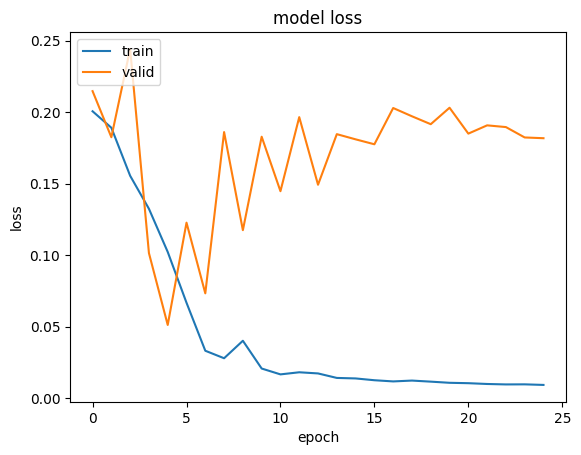

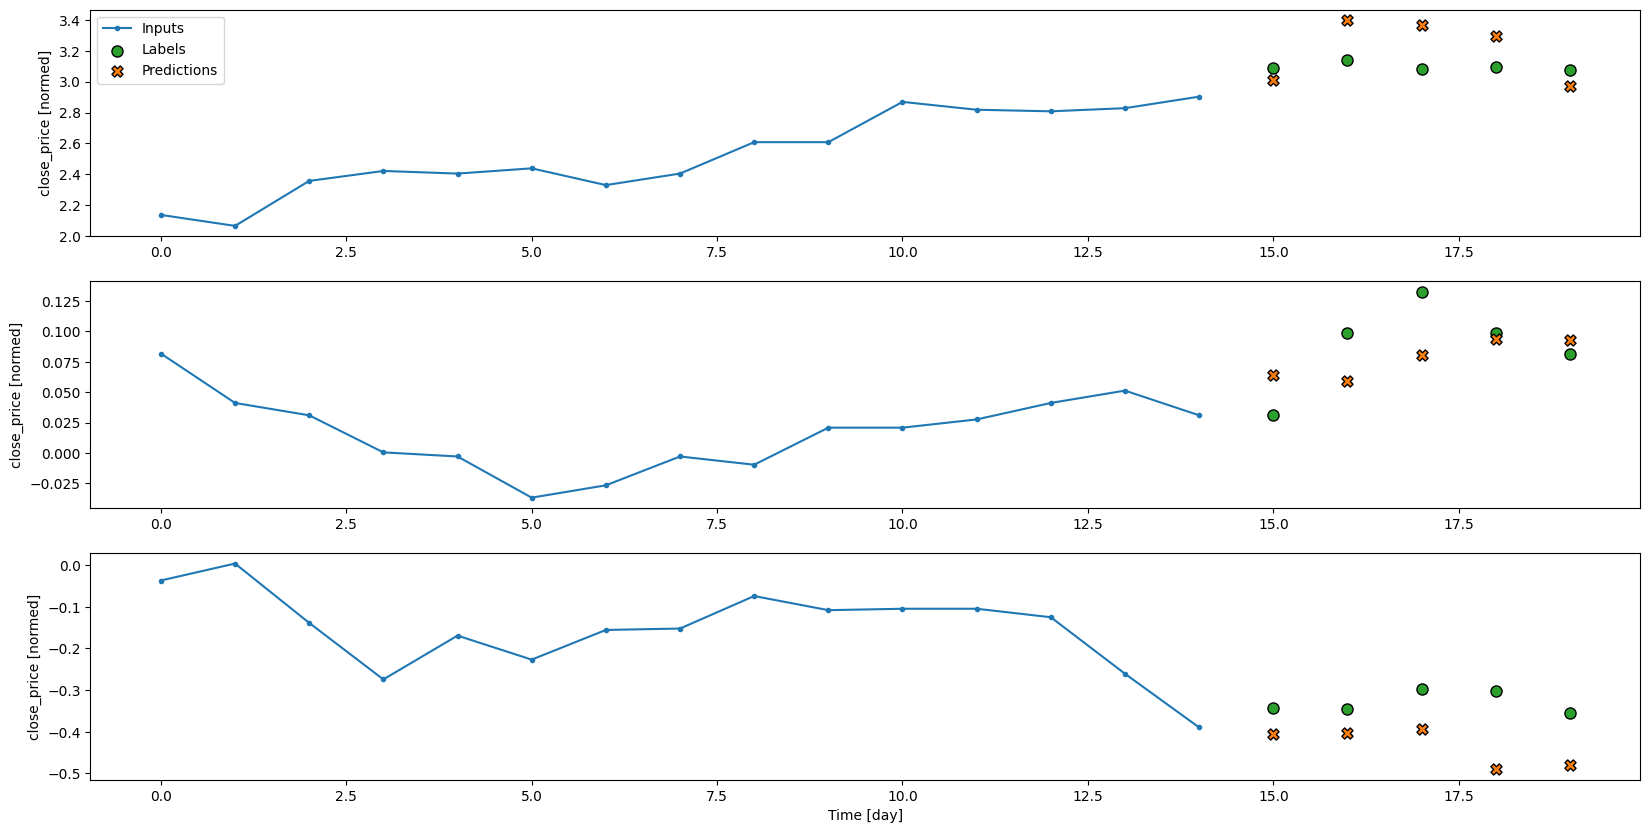

In [52]:
history_LSTM_Dense = compile_and_fit(LSTM_Dense_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.val)
multi_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.test, verbose=0)
plot_train(history_LSTM_Dense)
multi_window.plot(LSTM_Dense_model)

# RESULT 

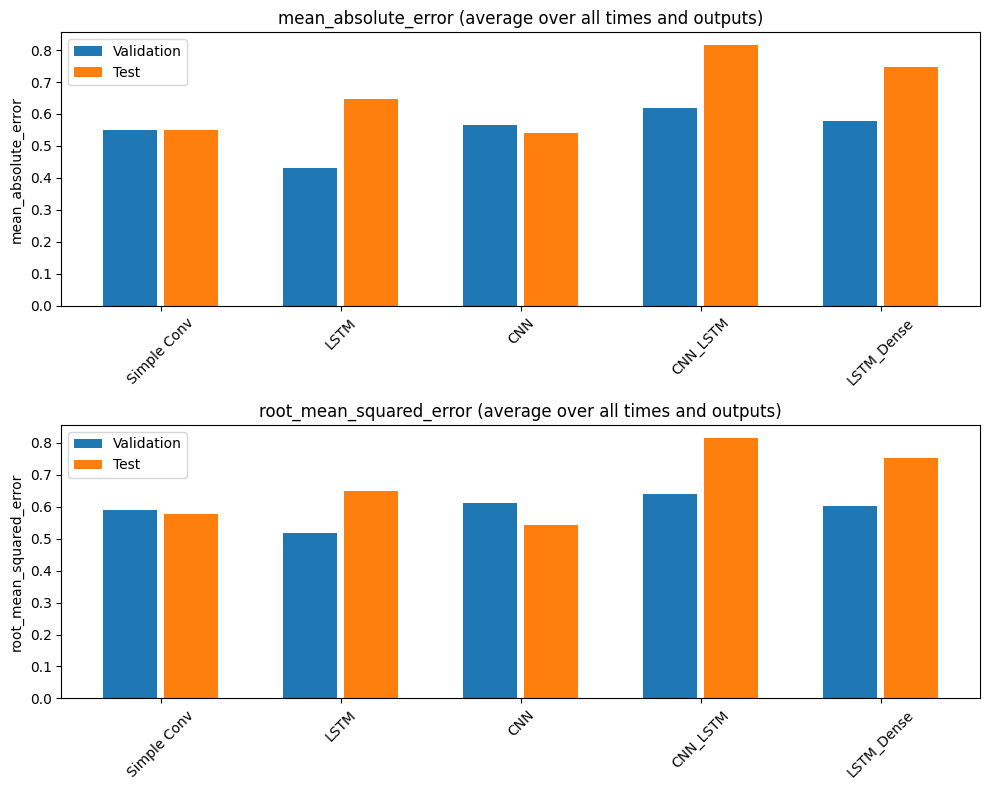

In [53]:
x = np.arange(len(multi_performance))
width = 0.3

plt.figure(figsize=(10, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)

metric_name = LSTM_Dense_model.metrics_names[1:] #we don't draw loss
for i, name in enumerate(metric_name,1):
    plt.subplot(2, 1, i)
    
    metric_index = LSTM_Dense_model.metrics_names.index(name)
    val_mae = [v[metric_index] for v in multi_val_performance.values()]
    test_mae = [v[metric_index] for v in multi_performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.title (f'{name} (average over all times and outputs)')
    plt.xticks(ticks=x, labels=multi_performance.keys(),
               rotation=45)
    plt.ylabel(f'{name}') #(average over all times and outputs)
    _ = plt.legend()
    
plt.tight_layout()

# INFERENCE

In [54]:
test_window = tf.stack([np.array(test_df[test_df.shape[0] - input_width: test_df.shape[0]])])


In [55]:
scaler = standardize_pipe.named_steps['standard scaler']

Denormalize prediction

In [56]:
def denorm(inputs,scaler, standardize_cols = standardize_cols):
    denorm_array = []
    for input in inputs:
        denorm_input = scaler.inverse_transform(input[:,:len(standardize_cols)])
        denorm_array.append(denorm_input)
    denorm_array = np.array(denorm_array,dtype=float)    
    return denorm_array

In [57]:
def plot_inference_denorm(self, model=None, plot_col='close_price', max_subplots=1, inputs = test_window, model_name = "model"):
    
    
    denorm_inputs = denorm(inputs, scaler)
    # print (denorm_input[:, plot_col_index])
    plt.figure(figsize=(20, 7))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [denormed]')
        plt.plot(self.input_indices, denorm_inputs[n,:, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if model is not None:
            predictions = model(inputs)
            denormalized_predictions = denorm(predictions,scaler)

            plt.scatter(self.label_indices, denormalized_predictions[n, :, plot_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            print (denormalized_predictions[n, :, plot_col_index])
            plt.title(model_name)
        if n == 0:
            plt.legend(loc='upper left')

    plt.xlabel('Time [day]')
    

WindowGenerator.plot_inference_denorm = plot_inference_denorm

All models

In [58]:
models = [multi_conv_model, multi_lstm_model, CNN_model,LSTM_Dense_model,CNN_LSTM_model]

dict_keys(['Simple Conv', 'LSTM', 'CNN', 'CNN_LSTM', 'LSTM_Dense'])
Simple Conv
[59.51347113 59.81868544 59.6899952  59.22524756 60.00411115]
LSTM
[62.40962488 62.27282432 62.20020737 62.21638622 62.31107443]
CNN
[57.78330397 57.47030577 57.33759011 57.28138923 57.12251926]
CNN_LSTM
[52.50891449 52.53280954 52.68220745 50.98504177 51.75484002]
LSTM_Dense
[65.21893483 62.85799784 62.44643651 63.12372774 63.72372693]


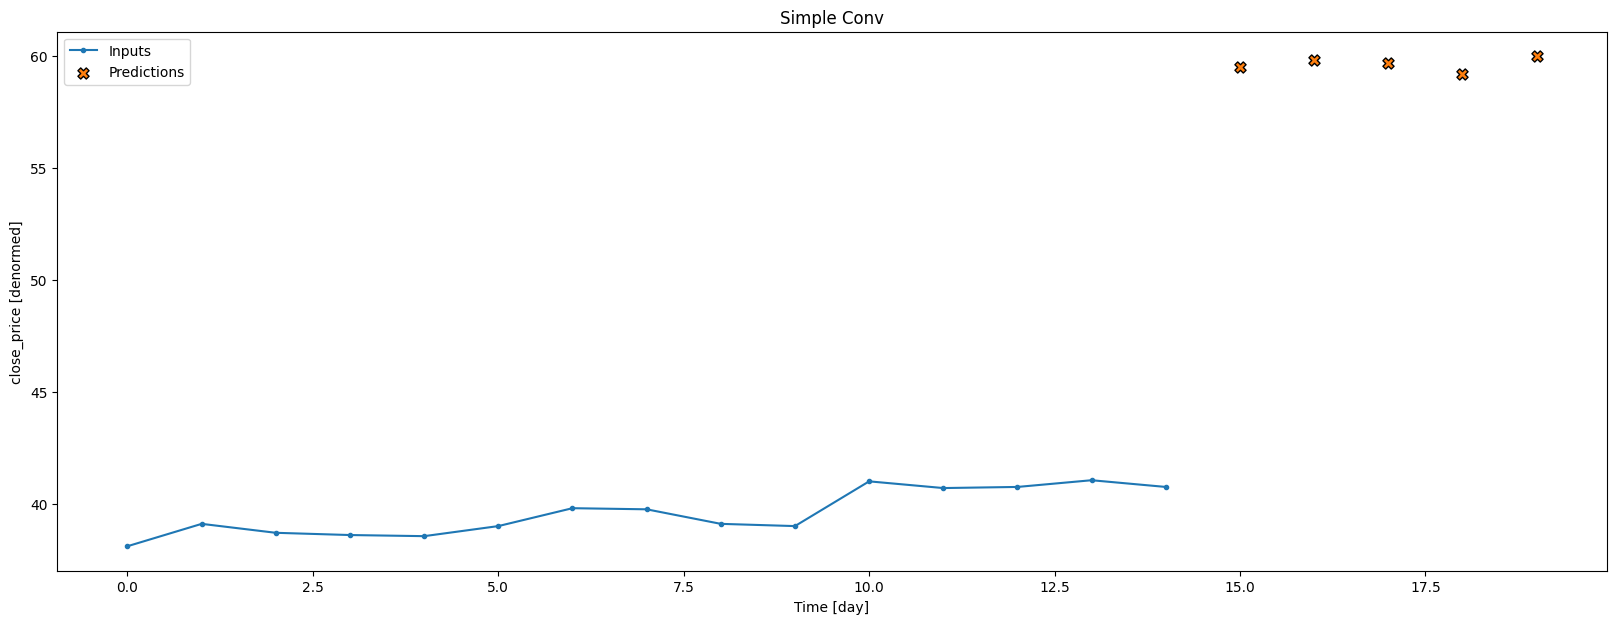

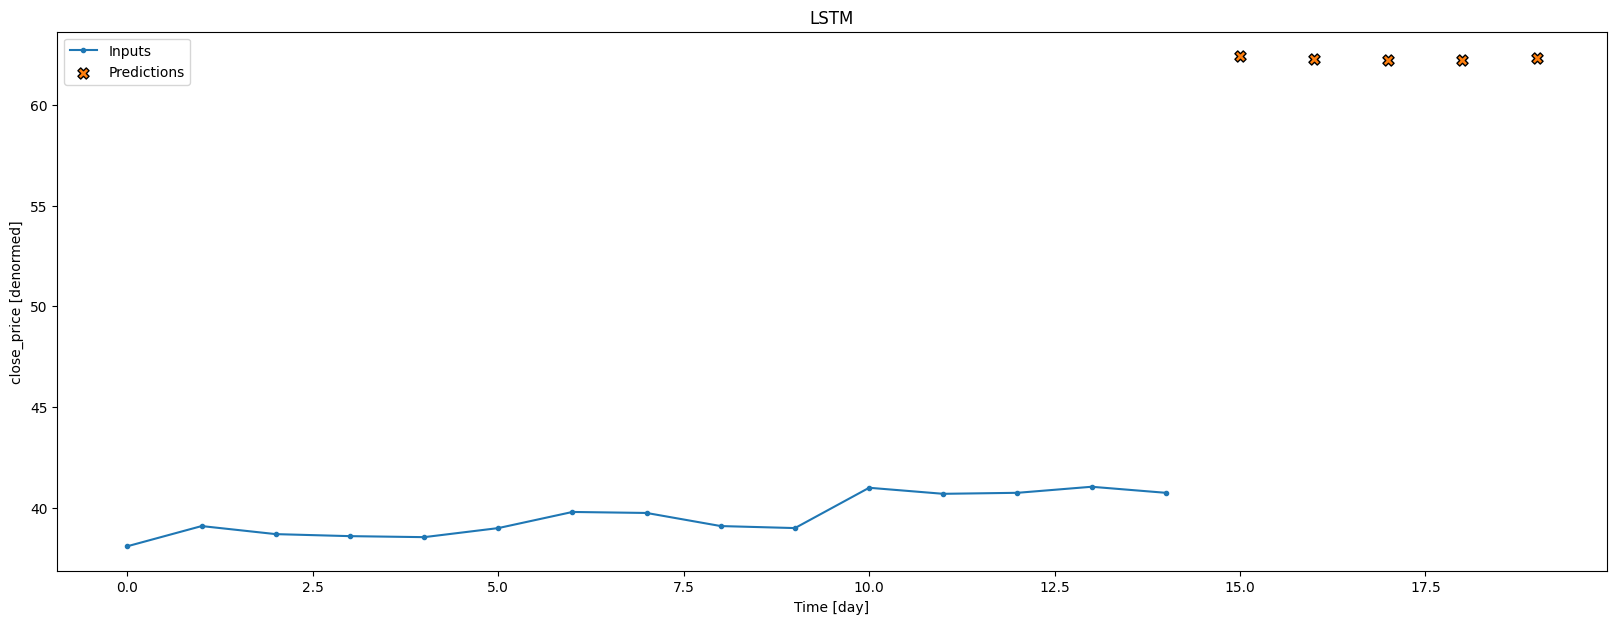

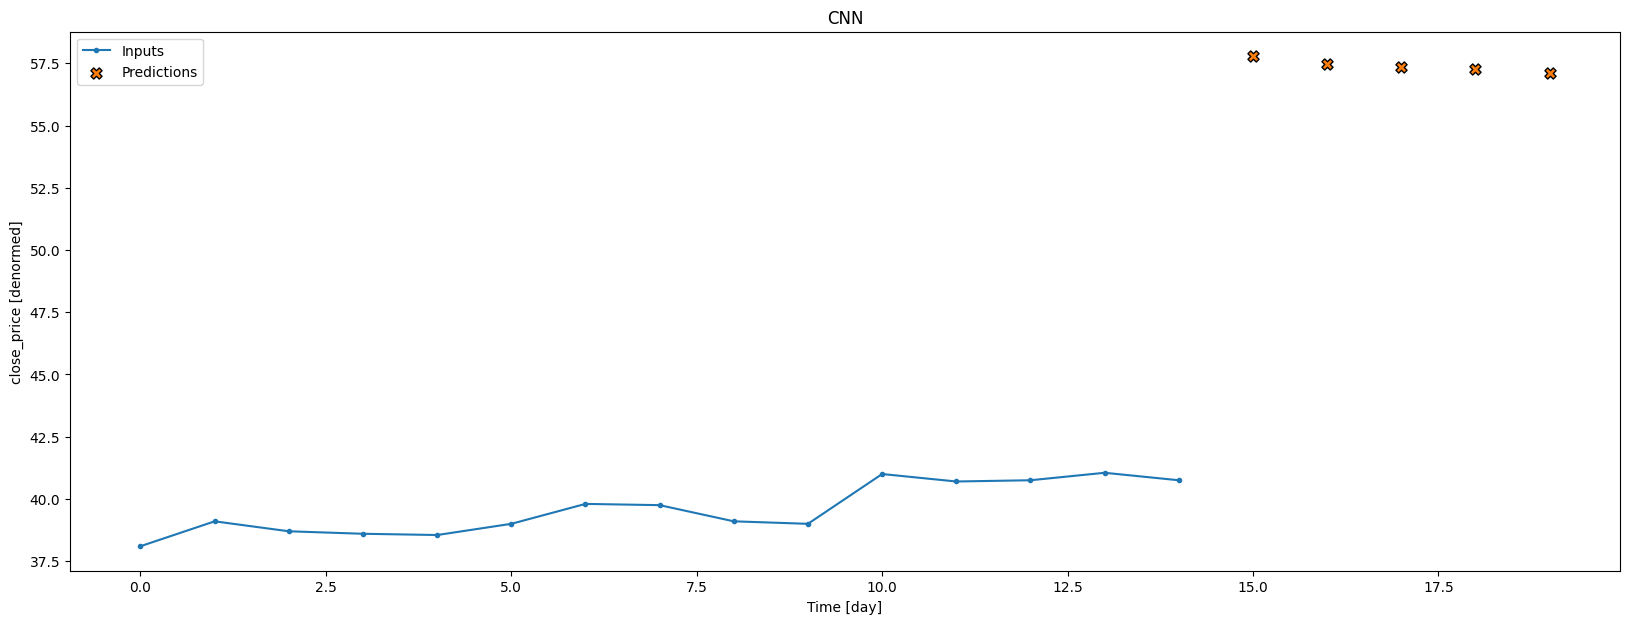

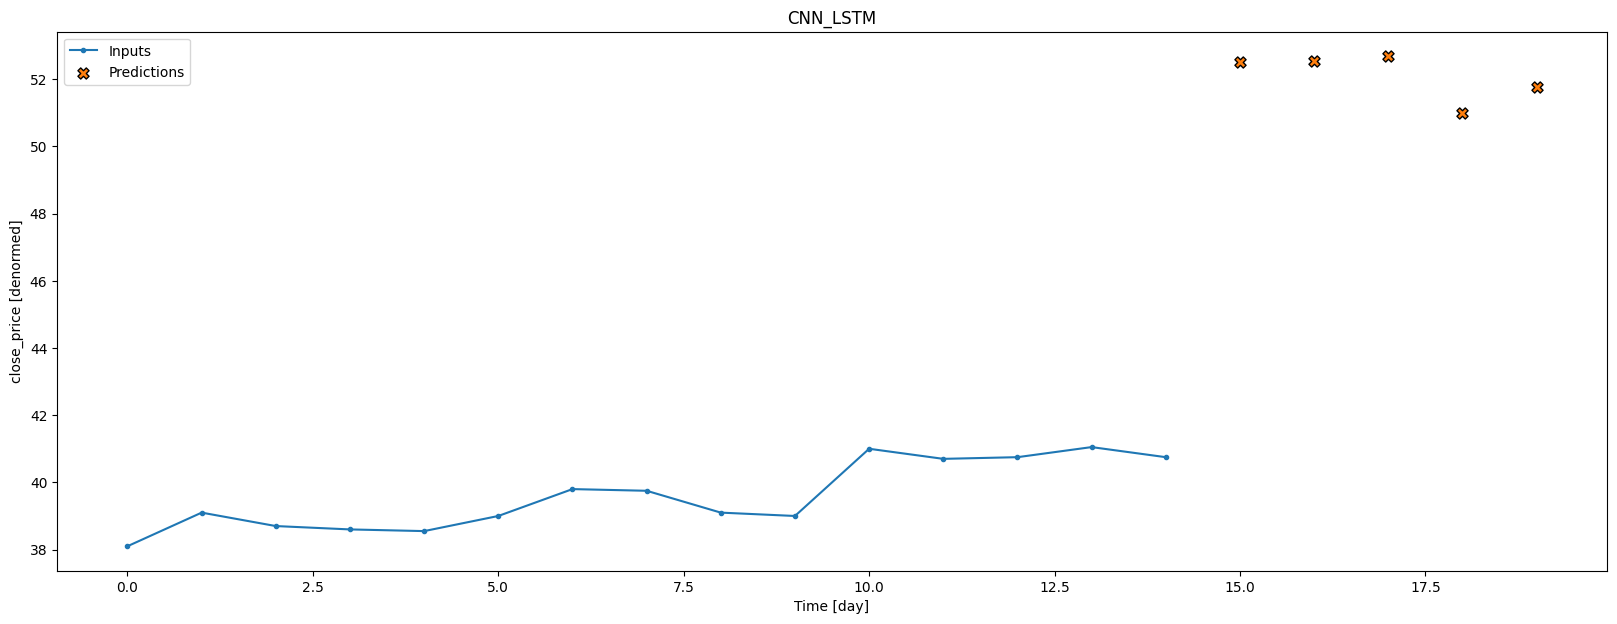

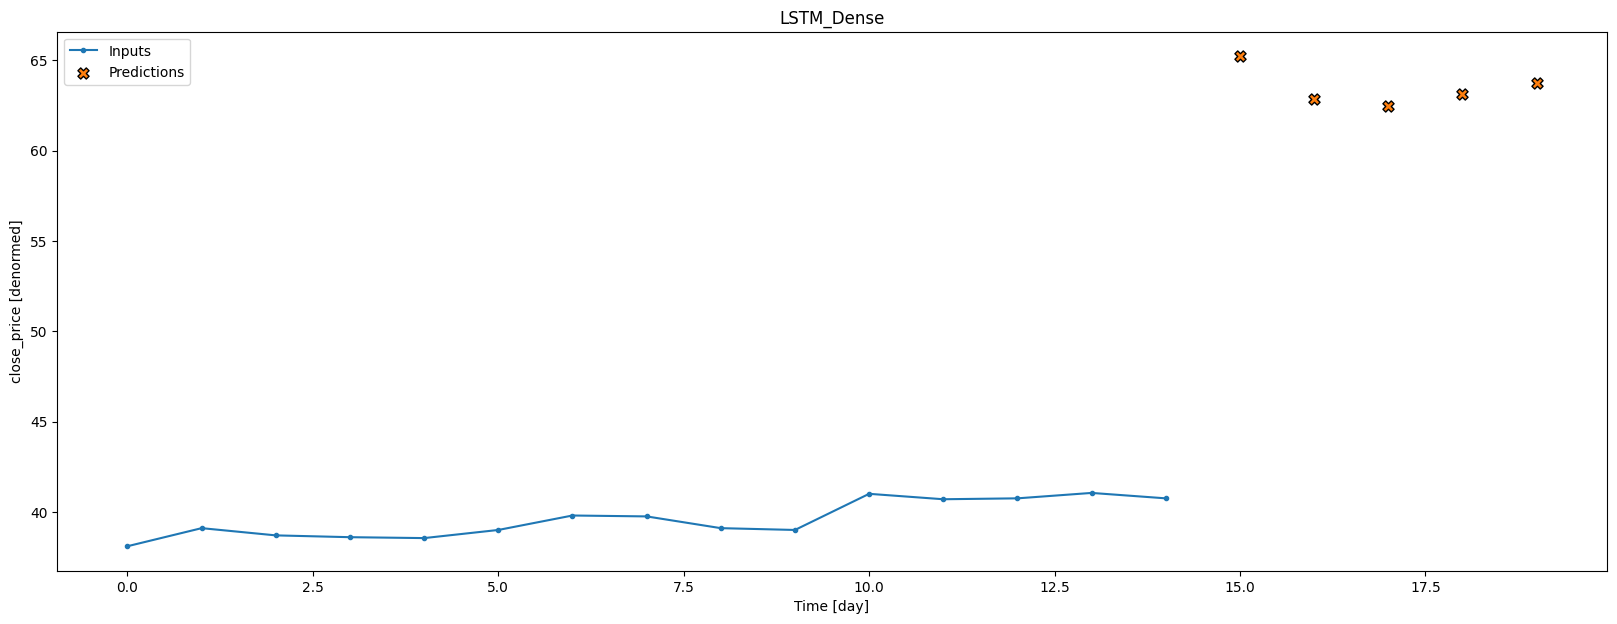

In [59]:
print(multi_performance.keys())
for model_name, model in zip(multi_performance.keys(), models):
    print (model_name)
    multi_window.plot_inference_denorm(model, model_name = model_name)

Feature importance

In [60]:
# Initialize empty lists for inputs and labels
all_inputs = []
all_labels = []

# Iterate over the dataset and append inputs and labels
for inputs, labels in multi_window.train:
    all_inputs.append(inputs.numpy())
    all_labels.append(labels.numpy())

# Convert the lists of inputs and labels to numpy arrays
all_inputs = np.concatenate(all_inputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Now, 'all_inputs' and 'all_labels' contain the entire dataset's inputs and labels


In [61]:
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def permutation_feature_importance(model, X, y_true):
    # Get the baseline performance of the model
    y_pred = model.predict(X, verbose = 0)
    baseline_mse = mean_squared_error(y_true, y_pred)

    # Initialize an array to store the importances
    feature_importances = np.zeros(X.shape[1])

    # Calculate the importance of each feature
    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        y_pred_permuted = model.predict(X_permuted)
        mse_permuted = mean_squared_error(y_true, y_pred_permuted)
        feature_importances[i] = baseline_mse - mse_permuted

    return feature_importances

In [62]:
def feature_impt (model,input = all_inputs, label = all_labels):
    # Calculate the feature importance
    feature_importances = permutation_feature_importance(model, all_inputs, all_labels)

    # Pair the feature importances with their names
    feature_importance_tuples = list(zip(train_df.columns, feature_importances))

    # Sort the feature importances from largest to smallest
    sorted_feature_importances = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

    # # Print the sorted feature importances
    # for feature, importance in sorted_feature_importances:
    #     print(f"{feature}: {importance}")
    return sorted_feature_importances

5/5 [==============================] - 0s 752us/step


C:\Users\baomc\AppData\Local\Temp\ipykernel_10032\1133872965.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(df.columns)


5/5 [==============================] - 0s 12ms/step


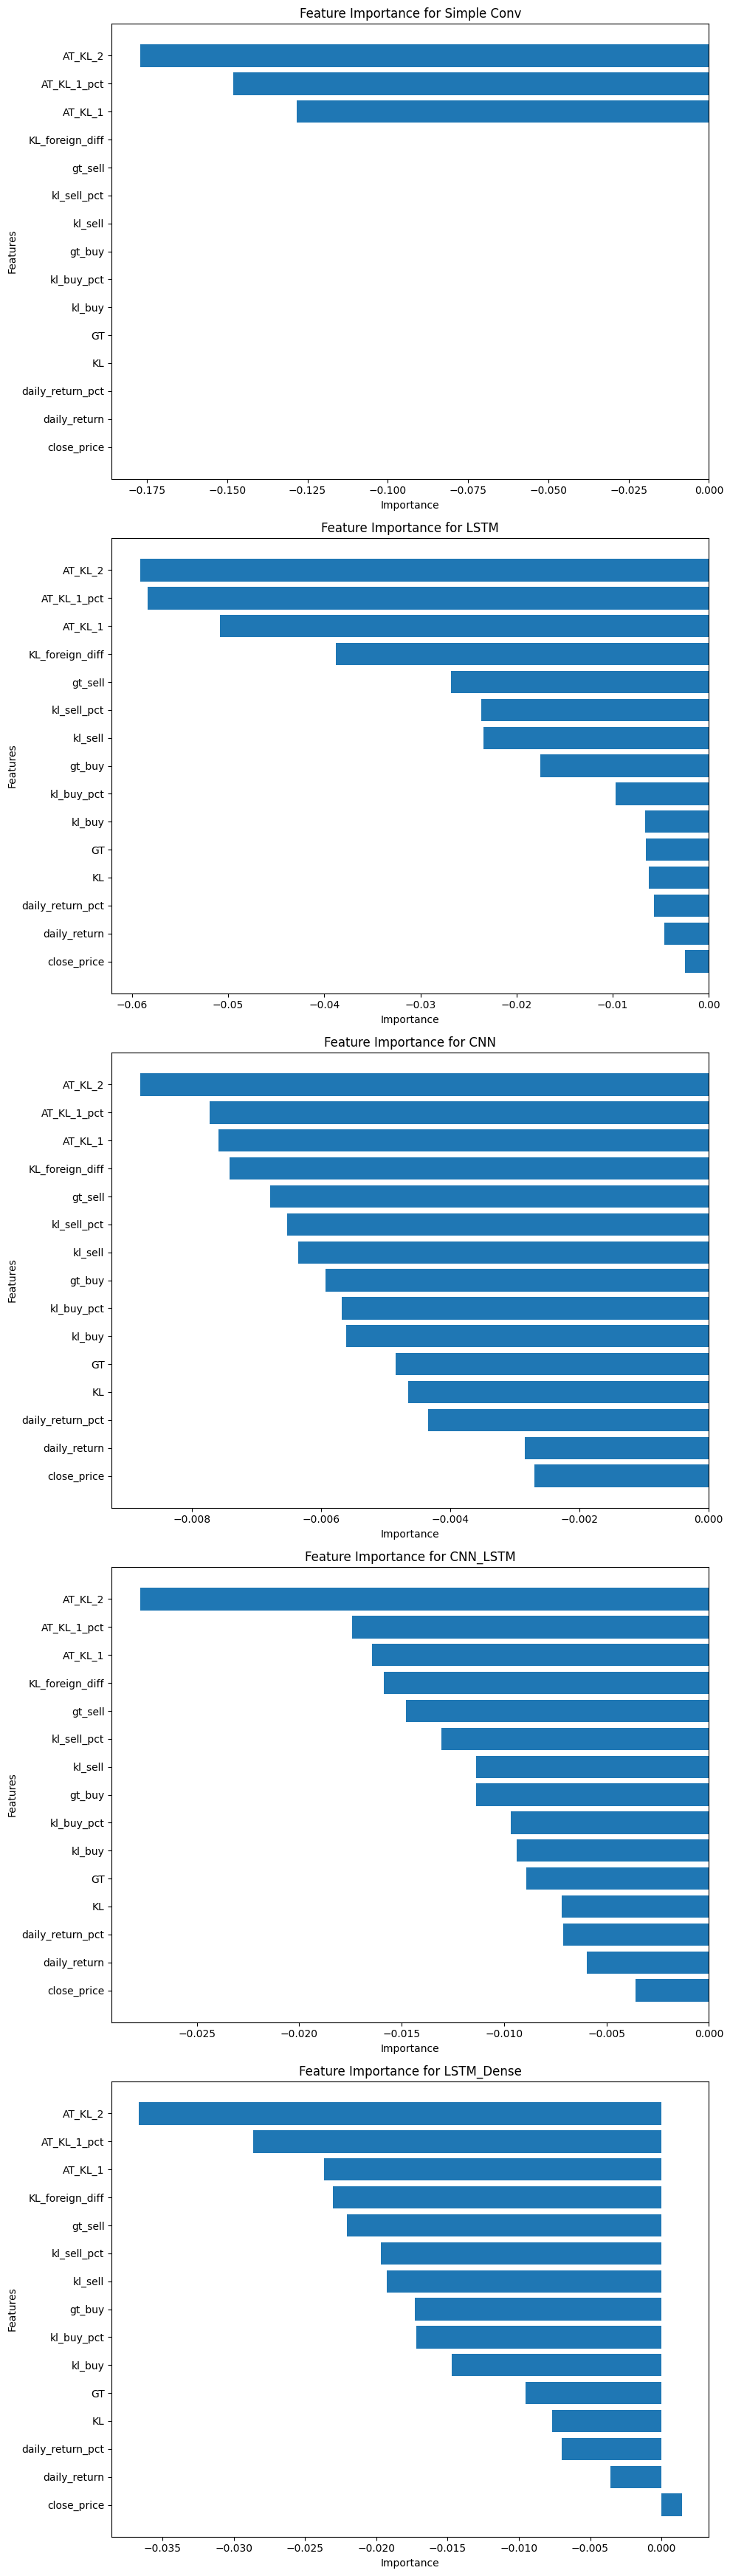

In [64]:
num_models = len(models)
fig, axs = plt.subplots(num_models, figsize=(10, 7 * num_models))

i = 0
for (model_name, model) in zip(list(multi_performance.keys()), models):
    # Calculate the feature importance for the current model
    sorted_feature_importances = feature_impt(model, all_inputs, all_labels)

    # Plot the sorted feature importances
    axs[i].barh([x[0] for x in sorted_feature_importances], [x[1] for x in sorted_feature_importances])
    axs[i].set_xlabel('Importance')
    axs[i].set_ylabel('Features')
    axs[i].set_title(f'Feature Importance for {model_name}')
    axs[i].set_yticklabels(df.columns)
    i += 1
plt.tight_layout()
plt.show()


# CONCLUSION

The foreign data in the EDA shows that they are not corelated much to the close_price. And you can see the models not perform well too